In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

In [3]:
print(inspect.getdoc(DCRemoval))
print('\n\nMain interface\n' + inspect.getdoc(DCRemoval.main))

Linear-phase DC Removal Filter
------------------------------

Sharp notch filter, peak-to-peak ripple of 0.42 dB.
Based on the Dual-MA system described in https://www.dsprelated.com/showarticle/58.php ,
Quad-MA is discussed but IMHO not worth the BRAM.

Args:
    window_len: Averaging window size, must be power of two. Controls the filter sharpness and the BRAM usage.
                Optimal value is 2048. 1024 may be good enough.
    dtype: Sfix or Complex (applies to real and imag channels separately)


Main interface
Args:
    input (DataValid): -1.0 ... 1.0 range, up to 18 bits

Returns:
    DataValid:  DC-free output, 18 bits(-1.0 ... 1.0 range). Saturates on overflow.
                Rounding it down to 12-bits (standard SDR IQ width) wont work,
                you need ~16 bits to reliably remove the DC-offset.


# Examples

## Remove DC component from complex signal

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...
100%|██████████| 8192/8192 [00:00<00:00, 9933.71it/s] 
INFO:sim:Flushing the pipeline to collect 8192 valid samples (currently have 8187)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


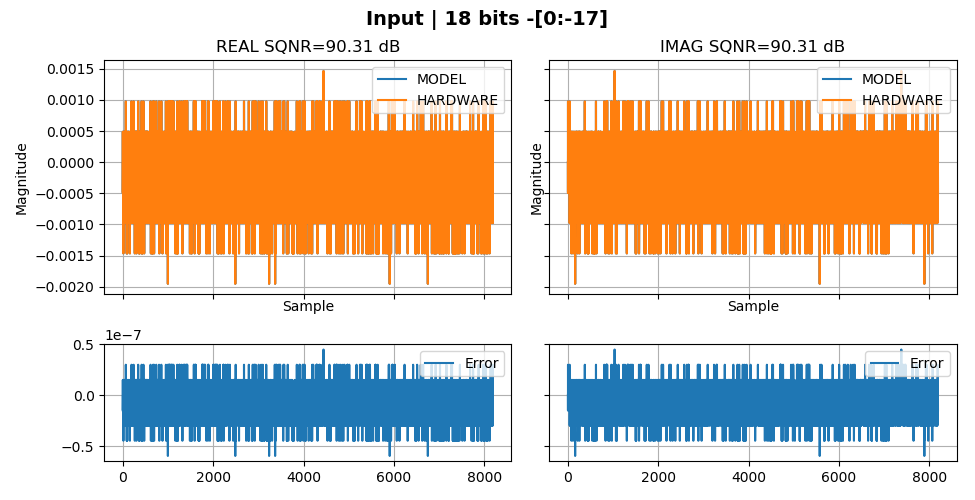

<IPython.core.display.Javascript object>


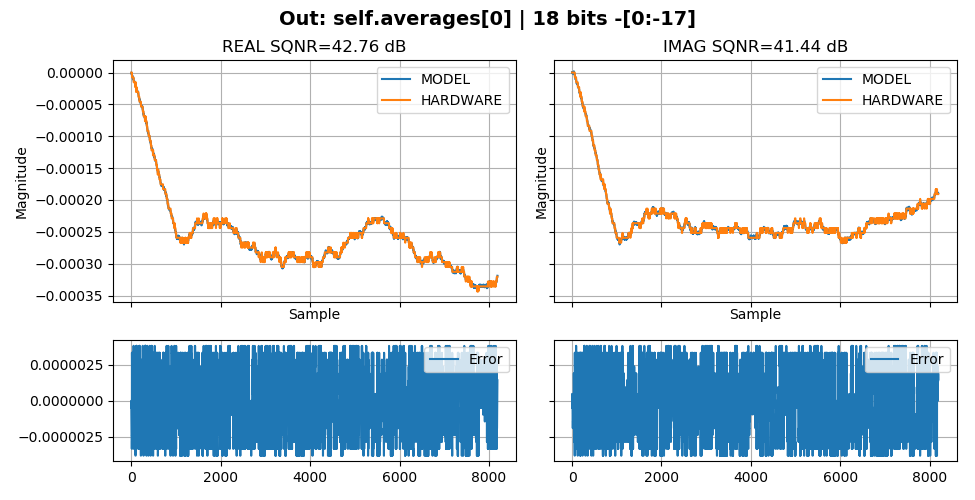

<IPython.core.display.Javascript object>


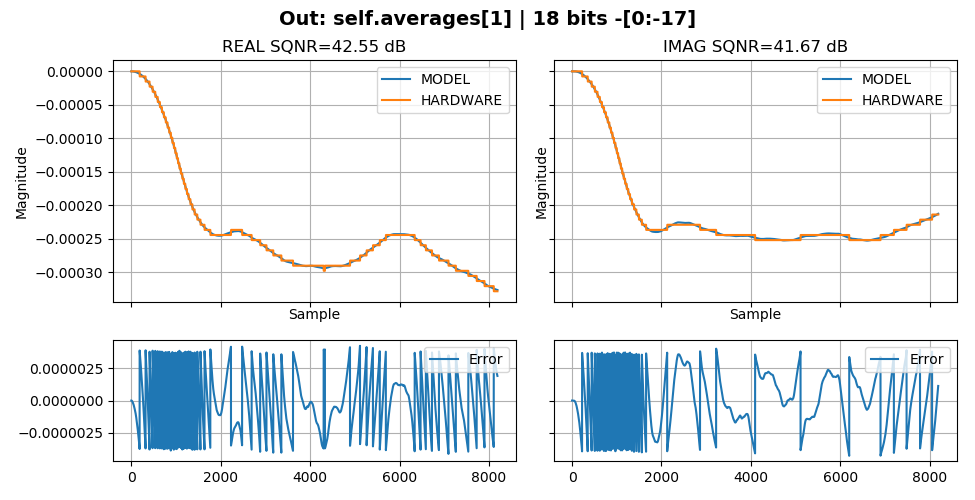

<IPython.core.display.Javascript object>


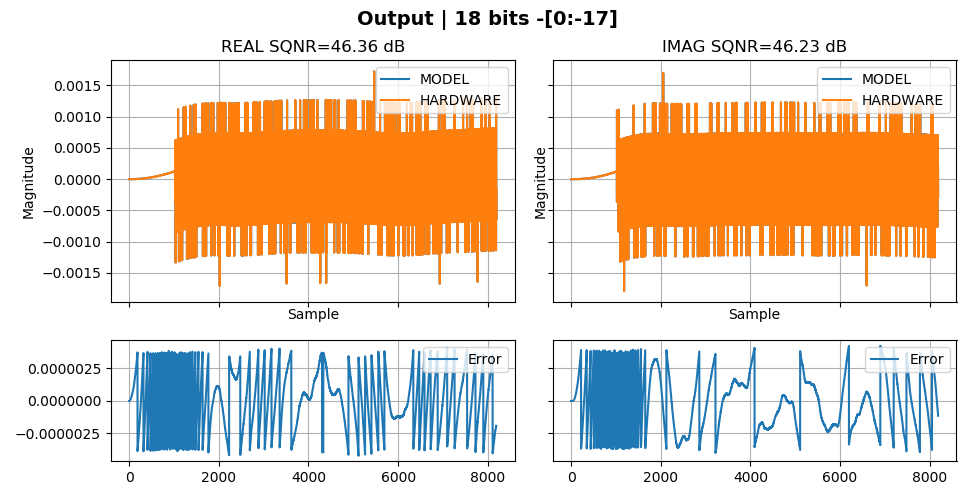

<IPython.core.display.Javascript object>


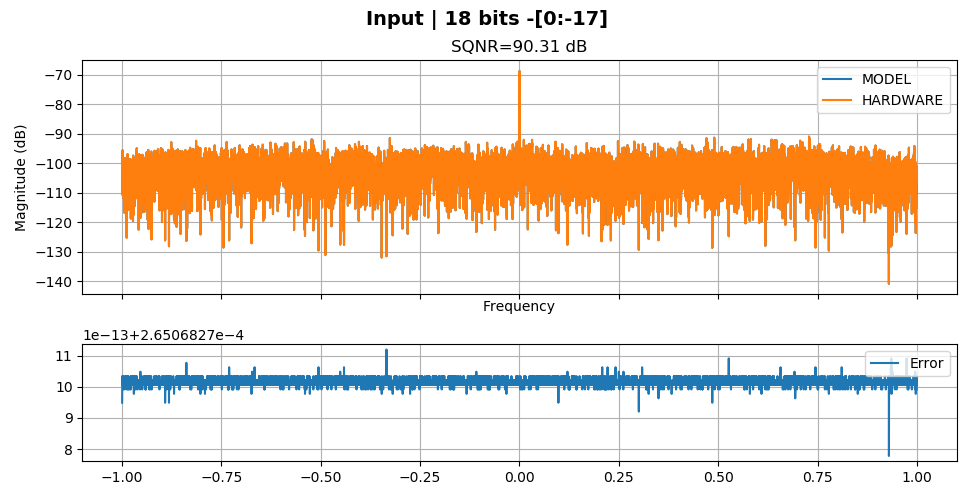

<IPython.core.display.Javascript object>


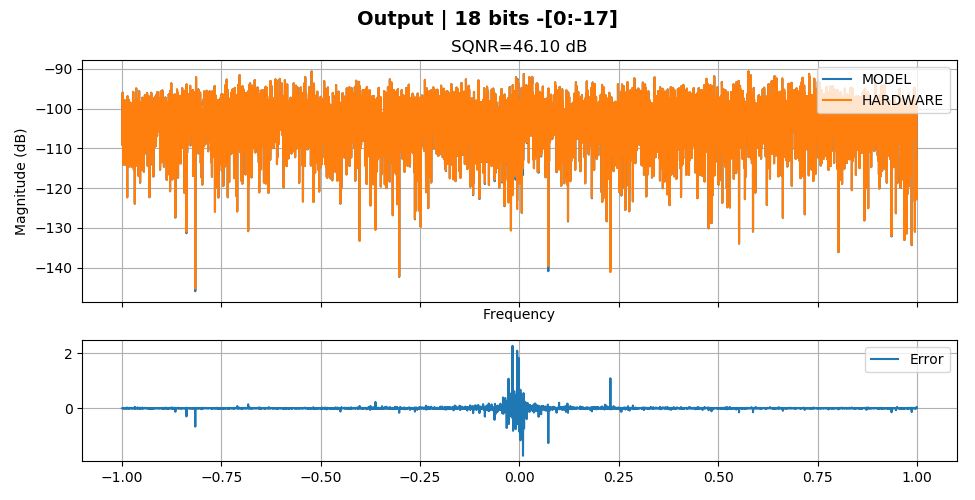

In [4]:
file = get_data_file('limem_ph3weak_40m')
input_signal = load_complex64_file(file)[:1024*8] # load your own IQ samples here!

dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace

plot_trace()
plot_trace_input_output(plotter=plot_frequency_domain)

## Frequency response

INFO:sim:Tracing is enabled, running "MODEL" and "HARDWARE" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "HARDWARE" simulation...
100%|██████████| 16384/16384 [00:01<00:00, 10434.99it/s]
INFO:sim:Flushing the pipeline to collect 16384 valid samples (currently have 16379)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


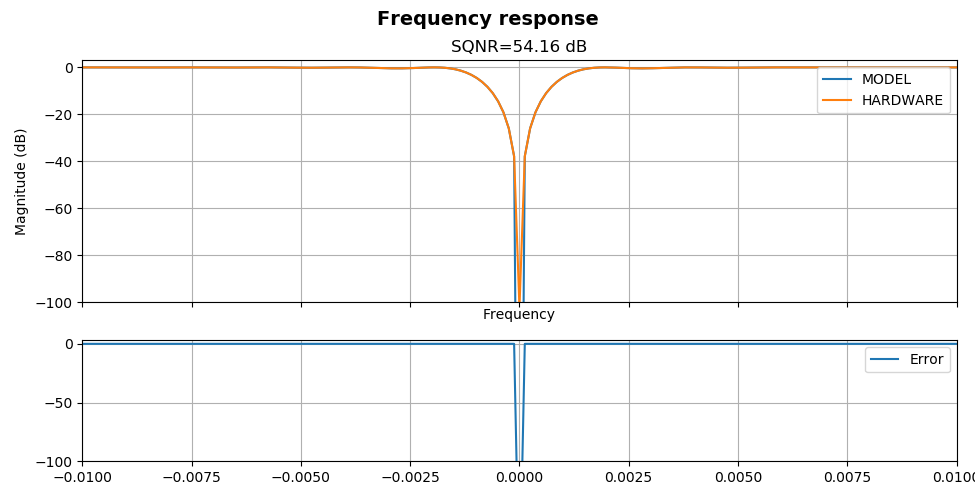

In [5]:
input_signal = [0.0 + 0.0j] * 1024 * 16
input_signal[0] = 1.0 + 1.0j
dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_frequency_response(sims, xlim=[-0.01, 0.01], ylim=[-100, 3])

# Conversion to VHDL and RTL/NETLIST simulations

In [6]:
# Pyha supports running 'RTL' (using GHDL) and 'NETLIST' (netlist after quartus_map) level simulations.
output_dir = '~/Documents/pyha_output'
input_signal = np.random.normal(size=1024) * 0.25
dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, pipeline_flush='auto', simulations=['MODEL', 'HARDWARE', 'RTL', 'NETLIST'], conversion_path=output_dir)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "HARDWARE" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 1651.16it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1019)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:conversion:Took 0.56 seconds
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 1029/1029 [00:01<00:00, 555.00it/s]

INFO:sim:OK!
INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
INFO:synth:Running quartus_eda quartus_project...
loading VPI module 

# Synthesis:  resource usage and Fmax

In [7]:
quartus = get_simulator_quartus() # reuse the work that was done during the simulation
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 114 / 39,600 ( < 1 % )
    Total combinational functions : 99 / 39,600 ( < 1 % )
    Dedicated logic registers : 78 / 39,600 ( < 1 % )
Total registers : 78
Total pins : 40 / 329 ( 12 % )
Total virtual pins : 0
Total memory bits : 2,250 / 1,161,216 ( < 1 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )

+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 199.08 MHz ; 199.08 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by